# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import matplotlib.pyplot as plt                        
%matplotlib inline

import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2       

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from PIL import Image, ImageFile 


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [54]:
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are total %d human images.' % len(human_files))
print('There are total %d dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


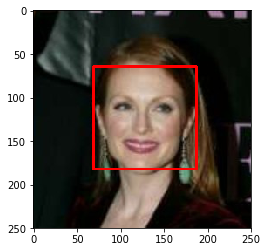

In [68]:
# extract pre-trained face detector
haar_face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread(human_files[50])

def test_face_detector(img, face_detector):
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # find faces in image
    faces = face_detector.detectMultiScale(gray)

    # print number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img,(x,y-4),(x+w+4,y+h),(0,0,255),2)

    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

test_face_detector(img, haar_face_cascade)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [69]:
# returns "True" if face is detected in image stored at img_path
def haar_face_detector(img_path):
    img = cv2.imread(img_path)
    gray = convertToRGB(img)
    faces = haar_face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
96% of the human faces are correctly detected but 16% of dog faces are also detected as human. This performance is acceptable but falls short of ideal in dog images.

In [70]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
detected_faces_in_humans = 0
detected_faces_in_dogs = 0

for ii in range(100):
    if haar_face_detector(human_files_short[ii]):
        detected_faces_in_humans += 1
    if haar_face_detector(dog_files_short[ii]):
        detected_faces_in_dogs +=1
        
print (f"Detected human faces: {detected_faces_in_humans}%")
print (f"Detected faces in dogs: {detected_faces_in_dogs}%")

Detected human faces: 96%
Detected faces in dogs: 16%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [72]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [73]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [43]:
def image_to_tensor(img_path):
    '''
    As per Pytorch documentations: All pre-trained models expect input images normalized in the same way, 
    i.e. mini-batches of 3-channel RGB images
    of shape (3 x H x W), where H and W are expected to be at least 224. 
    The images have to be loaded in to a range of [0, 1] and 
    then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
    You can use the following transform to normalize:
    '''
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    return image_tensor


# helper function for un-normalizing an image  - from STYLE TRANSFER exercise
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [74]:
#

In [5]:
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    img = Image.open(img_path)
    
    # VGG-16 takes 224x224 images as input, resize!
    # Convert PIL image into Tersor
    # Normailize input images to make its elements from 0 to 1
    data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    
    # Apply the transformation above
    img = data_transform(img)
    
    # PyTorch pretrained models expect the Tensor dims to be (num input imgs, num color channels, height, width).
    # Currently however, we have (num color channels, height, width); let's fix this by inserting a new axis. 
    # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img = img.unsqueeze(0)
    
    # Now that we have preprocessed our img, we need to convert it into a 
    # Variable; PyTorch models expect inputs to be Variables. A PyTorch Variable is a  
    # wrapper around a PyTorch Tensor.
    img = Variable(img)
    
    # Returns a Tensor of shape (batch, num class labels)
    prediction = VGG16(img)
    prediction = prediction.data.numpy().argmax()
    
    ## Return the *index* of the predicted class for that image
    return prediction

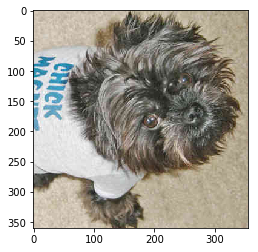

In [77]:
dog_image = Image.open('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00008.jpg')
plt.imshow(dog_image)
plt.show()


torch.Size([1, 3, 224, 224])


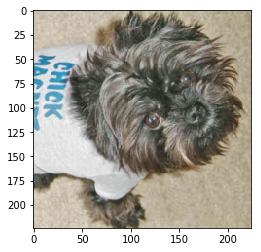

In [101]:
test_tensor = image_to_tensor('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00008.jpg')
# print(test_tensor)
print(test_tensor.shape)
plt.imshow(im_convert(test_tensor))

In [79]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image_tensor = image_to_tensor(img_path)
   
    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = VGG16(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 
    return int(pred)

In [103]:
# import requests
# import ast

LABELS_MAP_URL = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt"

def get_human_readable_label_for_class_id(class_id):
    labels = ast.literal_eval(requests.get(LABELS_MAP_URL).text)
    print(f"Label:{labels[class_id]}")
    return labels[class_id]
    
    
test_prediction = VGG16_predict('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00008.jpg')
pred_class = int(test_prediction)

print(f"Predicted class: {class_description.upper()}")

Predicted class: AFFENPINSCHER, MONKEY PINSCHER, MONKEY DOG


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [82]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    prediction = VGG16_predict(img_path)
#     print(prediction)
    return ((prediction >= 151) & (prediction <=268))

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
The dog detector correctly detects all of the dogs and only 1% humans are mistaken as dogs. This performance is pretty close to what we want.

In [83]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_detected = 0.0
dog_detected = 0.0

num_files = len(human_files_short)

for i in range(0, num_files):
    human_path = human_files_short[i]
    dog_path = dog_files_short[i]
    
    if dog_detector(human_path) == True:
        human_detected += 1
    if dog_detector(dog_path) == True:
        dog_detected += 1

print('VGG-16 Prediction')
print('The percentage of the detected dogs in Humans: {0:.0%}'.format(human_detected / num_files))
print('The percentage of the detected dogs in Dogs: {0:.0%}'.format(dog_detected / num_files))

VGG-16 Prediction
The percentage of the detected dogs in Humans: 1%
The percentage of the detected dogs in Dogs: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [7]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# Check if CUDA is available
use_cuda = torch.cuda.is_available()
print('CUDA is available:', use_cuda)

CUDA is available: True


Trasformations:

In [8]:
import torchvision.transforms as transforms

# Declare the transforms for train, valid and test sets.
# Imitate the VGG-16 model.
# Resize images because the input size of VGG-16 is 224x224
# Convert to Tensor
# Normalize images because the values of images should be loaded between [0 - 1]
transforms = {
    
    # Use RandomHorizontalFlip() to augement data in the train transformation
    'train' : transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    
    'valid' : transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    
    'test' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
}

Loaders for the datasets

In [9]:
from torchvision import datasets
from torchvision import utils
import os

# Number of subprocesses, if it's 0, it uses the main process.
num_workers = 0
# How many samples will be loaded for one batch?
batch_size = 20

# Create image datasets (train, valid, test)
image_datasets = {x: datasets.ImageFolder(os.path.join('/data/dog_images/', x), transforms[x])
                 for x in ['train', 'valid', 'test']}

# Create data loaders (train, valid, test)
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
               for x in ['train', 'valid', 'test']}

# Decrease batch size because of the out of memory in the GPU Instance
test_loader = torch.utils.data.DataLoader(image_datasets['test'], shuffle=True,
                                         batch_size=15)


sample info of data

In [23]:
# Check the dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

print('Number of records of training dataset: {}'.format(dataset_sizes['train']))
print('Number of records of validation dataset: {}'.format(dataset_sizes['valid']))
print('Number of records of test dataset: {}'.format(dataset_sizes['test']))

Number of records of training dataset: 6680
Number of records of validation dataset: 835
Number of records of test dataset: 836


In [24]:
# Get the all the breed labels
class_names = image_datasets['train'].classes
print(class_names)

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

In [25]:
# Get the number of classes
n_classes = len(class_names)
print('Number of classes: {}'.format(n_classes))

Number of classes: 133


In [26]:

# Display one record (input, label)
# The image should be normalized, the label is a integer value between 0 - 132
data_loaders['train'].dataset[6679]


(tensor([[[-1.3644, -1.3644, -1.3473,  ..., -1.6213, -1.6213, -1.6384],
          [-1.3302, -1.3473, -1.3473,  ..., -1.6727, -1.6727, -1.6727],
          [-1.3130, -1.3302, -1.3302,  ..., -1.6898, -1.6898, -1.6555],
          ...,
          [-0.3712, -0.3198, -0.2856,  ..., -0.3883, -0.3712, -0.3712],
          [-0.4054, -0.3541, -0.3198,  ..., -0.4226, -0.3712, -0.3027],
          [-0.4226, -0.3883, -0.3712,  ..., -0.4397, -0.3541, -0.2171]],
 
         [[-1.5980, -1.5980, -1.6155,  ..., -1.7556, -1.7556, -1.7731],
          [-1.6155, -1.6155, -1.6155,  ..., -1.7731, -1.7731, -1.7906],
          [-1.6155, -1.6155, -1.6155,  ..., -1.7731, -1.7731, -1.7906],
          ...,
          [-0.8277, -0.7927, -0.8102,  ..., -0.9328, -0.8978, -0.8978],
          [-0.8803, -0.8452, -0.8452,  ..., -1.0378, -0.9678, -0.8803],
          [-0.8978, -0.8803, -0.8803,  ..., -1.1429, -1.0203, -0.8627]],
 
         [[-1.5953, -1.6127, -1.6127,  ..., -1.6476, -1.6476, -1.6476],
          [-1.5953, -1.6127,

Visualising image transformations

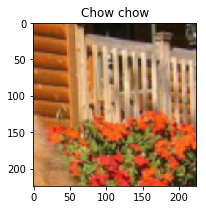

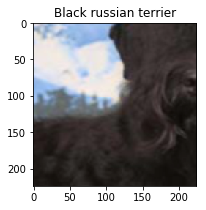

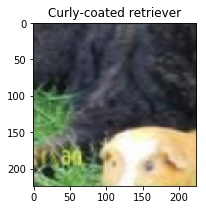

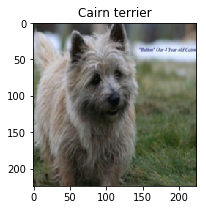

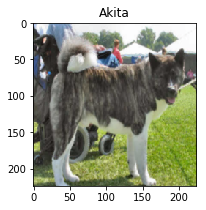

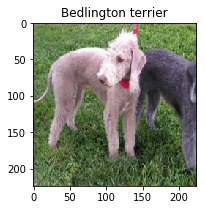

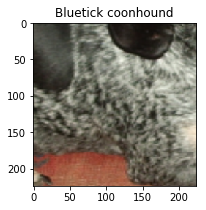

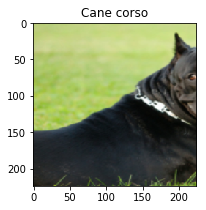

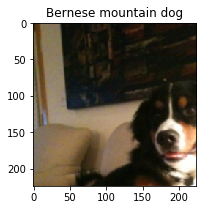

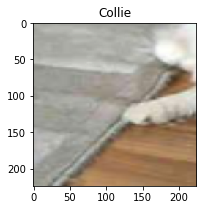

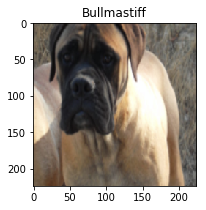

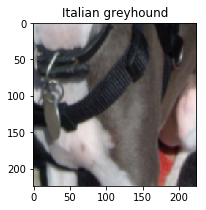

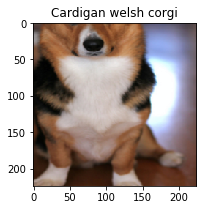

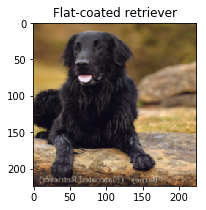

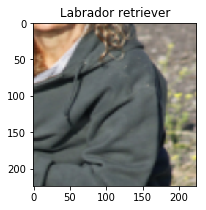

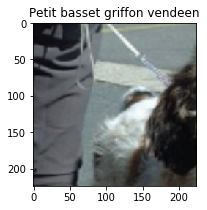

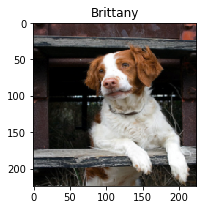

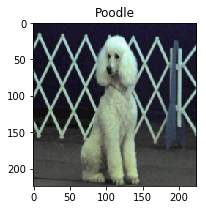

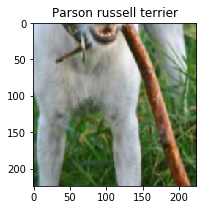

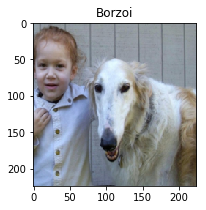

In [85]:
# import torchvision
# Get a batch of training data
inputs, classes = next(iter(data_loaders['train']))

for image, label in zip(inputs, classes): 
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
     
    fig = plt.figure(figsize=(12,3))
    plt.imshow(image)
    plt.title(class_names[label])



**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
I chose the size (256, 256) using transforms.resize() function. Most of the images are too big. If I used them in the orignal size of images, the calculations would take a lot of time and memory.

Yes, I augmented the dataset. I used RandomHorizontalFlip() and RadomResizeCrop() methods.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [10]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Follow the architecture of VGG-16
        # Size 224
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Size 112
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        # Size 56
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        # Size 28
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # Size 14
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        # Batch Normalization is a technique to improve performance and stability
        # of an artifical neural network.
        # It provides zero mean and unit variance as inputs to any layers.
        self.batch_norm64 = nn.BatchNorm2d(64)
        self.batch_norm128 = nn.BatchNorm2d(128)
        self.batch_norm256 = nn.BatchNorm2d(256)
        self.batch_norm512 = nn.BatchNorm2d(512)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout()
        
        # Size 7
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        # The Last fully connected layer's output is 133(Number of breeds)
        self.fc3 = nn.Linear(4096, 133)
    
    # Feedforward
    def forward(self, x):
        x = self.relu(self.batch_norm64(self.conv1_1(x)))
        x = self.relu(self.batch_norm64(self.conv1_2(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm128(self.conv2_1(x)))
        x = self.relu(self.batch_norm128(self.conv2_2(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm256(self.conv3_1(x)))
        x = self.relu(self.batch_norm256(self.conv3_2(x)))
        x = self.relu(self.batch_norm256(self.conv3_3(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm512(self.conv4_1(x)))
        x = self.relu(self.batch_norm512(self.conv4_2(x)))
        x = self.relu(self.batch_norm512(self.conv4_3(x)))
        x = self.max_pool(x)
        
        x = self.relu(self.batch_norm512(self.conv5_1(x)))
        x = self.relu(self.batch_norm512(self.conv5_2(x)))
        x = self.relu(self.batch_norm512(self.conv5_3(x)))
        x = self.max_pool(x)
        
        # It returns a new tensor which has a different size
        # and it's the same data of self tensor
        # The -1 means inferring the size from other dimensions.
        x = x.view(x.size(0), -1)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
# Create CNN instance!
model_scratch = Net()

# If CUDA is avaliable, Move Tensors to GPU
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

The input is always a 224x224 RGB image so the first layer has a size of (224,224,3).

The output layer should output 133 classes (for different breeds).

I added convolutional layers to detect the features from images, Maxpooling layers to reduce the x-y size of an input, keeping only the most active pixels from the previous layer as well as a few linear layers(with dropout to avoid overfitting) to finally produce a model that outputs 133 classes.

After multiple attempts at finalising the architecture, I was suggested by my mentor to try and make a replica of VGG16 for better accuracy. 

I kept the kernel Size 3x3, the smallest size to capture the notion of left/right, up/down, center.

The padding is 1 for the 3x3 kernel.

I have used the 2x2 maxpooling which is a common choice for similar problems. This reduces the size of image in half keeping only the most active pictures.

Activation Function: ReLU, quick to evaluate, does not saturate.

Convolutional Layers:

1-1 (3, 64) 1-2 (64, 64)

2-1(64, 128) 2-2 (128, 128)

3-1 (128, 256) 3-2 (256, 256) 3-3 (256, 256)

4-1 (256, 512) 4-2 (512, 512) 4-3 (512, 512)

5-1 (512, 512) 5-2 (512, 512) 5-3 (512, 512)

At the end I added two fully connected layers (4096 units, dropout) and one fully connected output layer(133 units, no dropout).

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [11]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()
### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [12]:
def train(n_epochs, train_loader, valid_loader,
          model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate batch loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # parameter update
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
            
        ######################
        # validate the model #
        ######################
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            
            # forward pass
            output = model(data)
            # batch loss
            loss = criterion(output, target)
            # update validation loss
            valid_loss += loss.item() * data.size(0)
        
        # calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        
        # print training/validation statistics 
        print('Epoch: {}\tTraining Loss: {:.6f}\t Validation Loss: {:.6f}'.
             format(epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                 format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    # return trained model
    return model

In [38]:
n_epochs = 20
# train the model
model_scratch = train(n_epochs, data_loaders['train'], data_loaders['valid'], model_scratch,
                     optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1	Training Loss: 4.596033	 Validation Loss: 4.437605
Validation loss decreased (inf --> 4.437605).    Saving model...
Epoch: 2	Training Loss: 4.457069	 Validation Loss: 4.281218
Validation loss decreased (4.437605 --> 4.281218).    Saving model...
Epoch: 3	Training Loss: 4.358316	 Validation Loss: 4.209170
Validation loss decreased (4.281218 --> 4.209170).    Saving model...
Epoch: 4	Training Loss: 4.292293	 Validation Loss: 4.107442
Validation loss decreased (4.209170 --> 4.107442).    Saving model...
Epoch: 5	Training Loss: 4.198324	 Validation Loss: 4.016764
Validation loss decreased (4.107442 --> 4.016764).    Saving model...
Epoch: 6	Training Loss: 4.103524	 Validation Loss: 3.932750
Validation loss decreased (4.016764 --> 3.932750).    Saving model...
Epoch: 7	Training Loss: 4.056980	 Validation Loss: 3.907392
Validation loss decreased (3.932750 --> 3.907392).    Saving model...
Epoch: 8	Training Loss: 4.001869	 Validation Loss: 3.833603
Validation loss decreased (3.907392

In [86]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [13]:
def test(loader, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [87]:
# call test function 
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.920534


Test Accuracy: 24% (207/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [14]:
# Load VGG-16 model
model_transfer = models.vgg16(pretrained=True)

# Freeze the pre-trained weights
for param in model_transfer.features.parameters():
    param.required_grad = False
    
# Get the input of the last layer of VGG-16
n_inputs = model_transfer.classifier[6].in_features

# Create a new layer(n_inputs -> 133)
# The new layer's requires_grad will be automatically True.
last_layer = nn.Linear(n_inputs, 133)

# Change the last layer to the new layer.
model_transfer.classifier[6] = last_layer

# Print the model.
print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
The pretrained models work very well as feature detectors even for images they weren't trained on. 

For this specific task I chose the VGG16 model as already suggested in the notebook. I also have tried to imitate the same myself but due to limited time, dataset and resources, the accuracy was pretty low so we can also see the difference between my model and the pretrained model.

I thought the VGG16 is sutable for the current problem  because it is already trained on the ImageNet dataset which is huge. This also reduces the overfitting concerns and we only need to initialize the weights of the fully connected layer.
The classifier part is a single fully connected layer with 1000 classes.
I have replaced that with 133 classes according to our requirements and retrained the model on the provided dataset while freezing the parameters of the convolutional layers..

I would also like to work with VGG19 in the future which has a slightly better accuracy than VGG16.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [15]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [17]:
n_epochs = 20
model_transfer = train(n_epochs, data_loaders['train'], data_loaders['valid'], model_transfer,
                     optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1	Training Loss: 4.238583	 Validation Loss: 3.042166
Validation loss decreased (inf --> 3.042166).    Saving model...
Epoch: 2	Training Loss: 2.682792	 Validation Loss: 1.560399
Validation loss decreased (3.042166 --> 1.560399).    Saving model...
Epoch: 3	Training Loss: 1.798532	 Validation Loss: 1.046715
Validation loss decreased (1.560399 --> 1.046715).    Saving model...
Epoch: 4	Training Loss: 1.475732	 Validation Loss: 0.837424
Validation loss decreased (1.046715 --> 0.837424).    Saving model...
Epoch: 5	Training Loss: 1.277818	 Validation Loss: 0.738349
Validation loss decreased (0.837424 --> 0.738349).    Saving model...
Epoch: 6	Training Loss: 1.210479	 Validation Loss: 0.665424
Validation loss decreased (0.738349 --> 0.665424).    Saving model...
Epoch: 7	Training Loss: 1.143899	 Validation Loss: 0.652885
Validation loss decreased (0.665424 --> 0.652885).    Saving model...
Epoch: 8	Training Loss: 1.074625	 Validation Loss: 0.598626
Validation loss decreased (0.652885

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [17]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [18]:
test(data_loaders['test'], model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.531704


Test Accuracy: 83% (699/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [88]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in  image_datasets['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = image_to_tensor(img_path)

    # move model inputs to cuda, if GPU available
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample outputs
    output = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

In [89]:
def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()

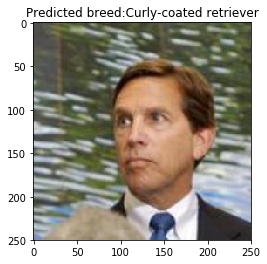

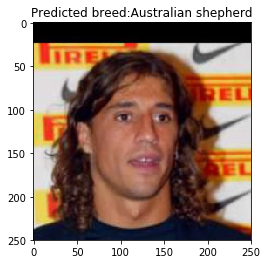

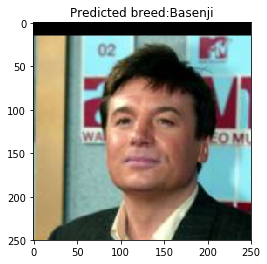

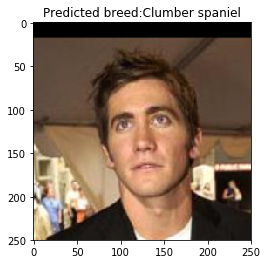

In [91]:
import random

# Try out the function
for image in random.sample(list(human_files_short), 4): 
    predicted_breed = predict_breed_transfer(image)
    display_image(image, title=f"Predicted breed:{predicted_breed}")

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [99]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    # check if image has juman faces:
    if (haar_face_detector(img_path)):
        print("Hello Human!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title="")
        
        print("You look like a ...")
        print(predicted_breed.upper())
    # check if image has dogs:
    elif dog_detector(img_path):
        print("Hello Doggie!")
        predicted_breed = predict_breed_transfer(img_path)
        display_image(img_path, title="")
        
        print("Your breed is most likley ...")
        print(predicted_breed.upper())
    else:
        print("Oh, we're sorry! We couldn't detect any dog or human face in the image.")
        display_image(img_path, title="...")
        print("Try another!")
    print("\n")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
1. Returning top n (say 3) resembling classes and not just one because another class might also have significant probability.
2. Pickling this model and serving this as an API for further use in an app.
3. Handling cases of multiple dogs/humans in an image.

Hello Human!


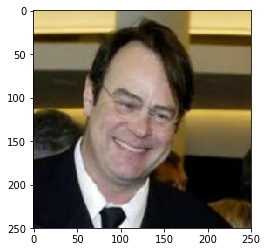

You look like a ...
CHINESE CRESTED


Hello Human!


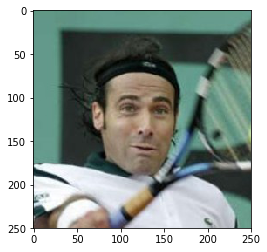

You look like a ...
DACHSHUND


Hello Human!


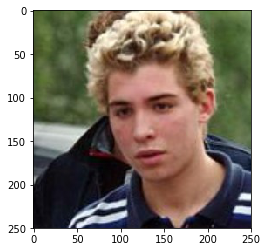

You look like a ...
AFGHAN HOUND


Hello Doggie!


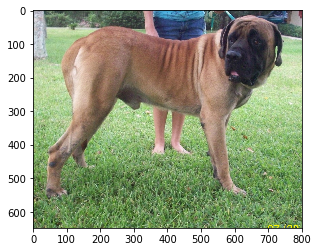

Your breed is most likley ...
MASTIFF


Hello Doggie!


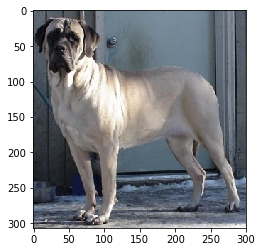

Your breed is most likley ...
MASTIFF


Hello Doggie!


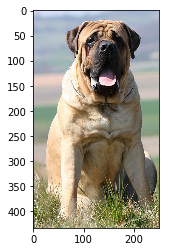

Your breed is most likley ...
CHINESE SHAR-PEI




In [100]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)